## Introduction

In [1]:
import hvplot.xarray
import numpy as np
import xarray as xr

In [2]:
def load_merged_argo_dataset_and_tumo(time_smoothing, lat_bounds = None):
    ds_argo_merged = xr.open_dataset(f'../rapid-geostrophic-reconstruction/data/ds_argo_{time_smoothing}.nc')
    t_umo_obs = xr.open_dataset(f'../rapid-geostrophic-reconstruction/data/t_umo_obs.nc')

    t_umo_obs = t_umo_obs.resample(time = time_smoothing).mean()

    ds_argo_merged = ds_argo_merged.sel(time = t_umo_obs.time.data, method = 'nearest')
    ds_argo_merged = ds_argo_merged.isel(z = slice(None, None, -1))

    if lat_bounds is not None:
        ds_argo_merged = ds_argo_merged.where((ds_argo_merged.lat >= lat_bounds[0]) & (ds_argo_merged.lat <= lat_bounds[1]))

    return ds_argo_merged, t_umo_obs

In [3]:
# Load the argo_dataset and the ground truth dataset

import xarray as xr
time_smoothing = '10D'

lat_bounds = (25, 27)


ds_argo_merged, t_umo_obs = load_merged_argo_dataset_and_tumo(time_smoothing)#, lat_bounds = lat_bounds)

## Latitude bounds (no clue which code this is)

In [41]:
import numpy as np
lon_min , lon_max = ds_argo_merged.lon.min(),ds_argo_merged.lon.max() 
lat_min , lat_max = ds_argo_merged.lat.min(),ds_argo_merged.lat.max() 


lon_bin = np.arange(lon_min, lon_max, 6) 
lat_bin = np.arange(lat_min, lat_max, 6) 



In [42]:
lon_min, lon_max, lat_min, lat_max

(<xarray.DataArray 'lon' ()>
 array(-82.87867737),
 <xarray.DataArray 'lon' ()>
 array(-10.6491003),
 <xarray.DataArray 'lat' ()>
 array(23.66731071),
 <xarray.DataArray 'lat' ()>
 array(31.62044907))

In [43]:
lon_bin = np.linspace(-88, -10, 30)
lon_bin, np.diff(lon_bin)

(array([-88.        , -85.31034483, -82.62068966, -79.93103448,
        -77.24137931, -74.55172414, -71.86206897, -69.17241379,
        -66.48275862, -63.79310345, -61.10344828, -58.4137931 ,
        -55.72413793, -53.03448276, -50.34482759, -47.65517241,
        -44.96551724, -42.27586207, -39.5862069 , -36.89655172,
        -34.20689655, -31.51724138, -28.82758621, -26.13793103,
        -23.44827586, -20.75862069, -18.06896552, -15.37931034,
        -12.68965517, -10.        ]),
 array([2.68965517, 2.68965517, 2.68965517, 2.68965517, 2.68965517,
        2.68965517, 2.68965517, 2.68965517, 2.68965517, 2.68965517,
        2.68965517, 2.68965517, 2.68965517, 2.68965517, 2.68965517,
        2.68965517, 2.68965517, 2.68965517, 2.68965517, 2.68965517,
        2.68965517, 2.68965517, 2.68965517, 2.68965517, 2.68965517,
        2.68965517, 2.68965517, 2.68965517, 2.68965517]))

In [44]:
lat_bin = [20,26,32]
lat_bin = np.linspace(20, 32, 50)
lon_bin = np.linspace(-88, -10, 30)
# lon_bin = [-88, -82, -76, -70, -64, -58, -52, -46, -40, -34, -28, -22, -16, -10]

lon_cent = lon_bin[:-1] + np.diff(lon_bin)/2
lat_cent = lat_bin[:-1] + np.diff(lat_bin)/2

In [45]:
%%time
def group_lat(x):
    # x is a DataFrame of group values
    # now find the value of the longitude box to append to the dictionary key
    value = np.ones(1)
    value[0] = x.lon.mean()
    idx = (np.abs(lon_cent - value)).argmin()
    lokey = lon_cent[idx] # longitude value of the box

    # compute groups for the latitude
    y = x.groupby_bins('lat', lat_bin, labels=lat_cent)
    y = dict(y)
    # replace the old key with the new key: lon,lat
    key = np.asarray((list(y.keys()))) # get dict keys as array
    newkey = np.stack((np.ones(len(key))*lokey,key),axis=1)
    newkey = tuple(newkey.tolist())
    key = tuple(y.keys()) # get dict keys as list

    for i in range(len(key)):
        y[tuple(newkey[i])] = y[key[i]]
        del y[key[i]]  
    return y


CPU times: user 20 µs, sys: 1e+03 ns, total: 21 µs
Wall time: 43.2 µs


In [46]:
def bin_argo_time_slice(ds_argo_ti):

    #geop_mean = geop1.groupby_bins('lon', lon_bin, labels=lon_cent).apply(group_lat)
    geop_mean = ds_argo_ti.groupby_bins('lon', lon_bin, labels=lon_cent)
    geop_mean = dict(geop_mean)


    l = 0
    geo_grid = dict()

    for x in list(geop_mean.keys()):
        y = group_lat(geop_mean[x])
        if l == 0:
            geo_grid = y
        else:
            geo_grid.update(y)
        l += 1
    
    l = 0
    m = np.zeros((len(tuple(geo_grid.keys())),4))
    d = np.asarray(list(geo_grid.keys()))

    gp = xr.Dataset(
        {
            'rho': (['lat','lon', 'z'],np.full((lat_cent.shape[0],lon_cent.shape[0], ds_argo_ti.z.shape[0]), np.nan)),
        },
        coords={
            'lon': (['lon'],lon_cent),
            'lat': (['lat'],lat_cent),
            'z': ds_argo_ti.z
        }
    )

    for k in range(d.shape[0]):
        e = tuple(d[k])
        #m[l,2] = geo_grid[e].z.mean()

        if geo_grid[e].pos.shape[0] < 1:
            continue

        try:
            gp['rho'].loc[dict(lat=d[k][1], lon=d[k][0])] = geo_grid[e].rho.mean('pos')
        except:
            print(geo_grid[e].rho.mean('pos'))
            raise ValueError('Error')
        # gp['z'].loc[dict(lat=d[k][1], lon=d[k][0])] = geo_grid[e].z
        #gp.loc[dict(lat=m[0,1], lon=m[0,0])]
        l +=1

    return gp

In [47]:
# for i in range(0,ds_argo_merged.time.shape[0]):
#     binned_ti = bin_argo_time_slice(ds_argo_merged.isel(time = i))
    
# binned_ti.ass


interpolated_merged_argo = xr.concat([bin_argo_time_slice(ds_argo_merged.isel(time = i)) for i in range(ds_argo_merged.time.shape[0])], dim = 'time').assign_coords(time = ds_argo_merged.time)


KeyboardInterrupt: 

In [ ]:
# standardize the rho values at the bins
from copy import deepcopy


rho_mean = interpolated_merged_argo.rho.mean(['time', 'lon', 'lat'])
rho_std = interpolated_merged_argo.rho.std(['time', 'lon', 'lat', 'z'])

def standardize_rho(ds_pos, rho_mean=None, rho_std=None):
    ds_pos = deepcopy(ds_pos)
    ds_pos["rho"] = (ds_pos["rho"] - rho_mean) / rho_std
    return ds_pos

interpolated_merged_argo_std = standardize_rho(
    interpolated_merged_argo,
    rho_mean=rho_mean, 
    rho_std=rho_std,
)

In [ ]:
import hvplot.xarray


interpolated_merged_argo_std.isel(lat = 1, time = 50).rho.hvplot(x = 'lon', y = 'z')

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


:Image   [lon,z]   (rho)

In [ ]:
blocks_permuted_indices = np.concatenate([np.arange(starti, min(starti+12, interpolated_merged_argo.time.shape[0])) for starti in np.random.permutation(np.arange(0, interpolated_merged_argo.time.shape[0], 12))])

train_indices = blocks_permuted_indices[:int(.75 * blocks_permuted_indices.shape[0])]
test_indices = blocks_permuted_indices[int(.75 * blocks_permuted_indices.shape[0]):]

X_dataset = interpolated_merged_argo.rho.stack(feature = ('lat', 'lon', 'z')).fillna(0).values


train_X = X_dataset[train_indices]
test_X = X_dataset[test_indices]


train_y = t_umo_obs.dv_dz_times_X.values[train_indices]
test_y = t_umo_obs.dv_dz_times_X.values[test_indices]

In [ ]:
from sklearn.linear_model import Lasso, Ridge



ridge = Lasso(alpha=5).fit(train_X, train_y)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.329e-01, tolerance: 2.635e-01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10), max_iter=1000, alpha=5,
                    solver='adam', verbose=10,  random_state=21,tol=0.000000001, learning_rate_init=1e-4, learning_rate='adaptive', validation_fraction=.1)

mlp.fit(train_X, train_y)

Iteration 1, loss = 172.11910602
Iteration 2, loss = 273.03244384
Iteration 3, loss = 55.54690028
Iteration 4, loss = 81.64439699
Iteration 5, loss = 65.78117902
Iteration 6, loss = 37.90241612
Iteration 7, loss = 27.94707913
Iteration 8, loss = 29.94755775
Iteration 9, loss = 32.72234550
Iteration 10, loss = 31.38964151
Iteration 11, loss = 25.83137368
Iteration 12, loss = 19.53154576
Iteration 13, loss = 17.08384722
Iteration 14, loss = 16.94231016
Iteration 15, loss = 15.94262322
Iteration 16, loss = 14.38026522
Iteration 17, loss = 12.34320599
Iteration 18, loss = 9.86092165
Iteration 19, loss = 8.68550761
Iteration 20, loss = 8.63411829
Iteration 21, loss = 8.72574199
Iteration 22, loss = 7.87601171
Iteration 23, loss = 7.22240428
Iteration 24, loss = 6.64603663
Iteration 25, loss = 6.09328937
Iteration 26, loss = 5.78839404
Iteration 27, loss = 5.45721498
Iteration 28, loss = 4.96978982
Iteration 29, loss = 4.35849088
Iteration 30, loss = 3.80417218
Iteration 31, loss = 3.5789481

MLPRegressor(alpha=5, hidden_layer_sizes=(10, 10, 10, 10),
             learning_rate='adaptive', learning_rate_init=0.0001, max_iter=1000,
             random_state=21, tol=1e-09, verbose=10)

In [ ]:
ridge.score(test_X, test_y)
# mlp.score(test_X, test_y)

-0.4769030208555176

In [ ]:
import pandas as pd

estimator = ridge

train_prediction = estimator.predict(train_X)
test_prediction = estimator.predict(test_X)

result_dataframe_train = pd.DataFrame({
    'time': t_umo_obs.time.data[train_indices],
    'true': train_y,
    'prediction': train_prediction,
})

result_dataframe_test = pd.DataFrame({
    'time': t_umo_obs.time.data[test_indices],
    'true': test_y,
    'prediction': test_prediction,
    'difference': test_y - test_prediction,
})

In [ ]:
result_dataframe_test.hvplot.line(x='time', y=['true', 'prediction'])

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [ ]:
import hvplot.pandas
(
    result_dataframe_train.hvplot.line(x='time', y=['true', 'prediction'])
    + result_dataframe_test.hvplot.line(x='time', y=['true', 'prediction'])
    # + result_dataframe_test.hvplot.line(x='time', y='difference')
).cols(1)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

:Layout
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [time]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [time]   (value)

## Merge Argos with naive fix sized bins

In [4]:
lon_bin = np.linspace(-88, -10, 30)

lon_bined_argos = xr.concat([ds_argo_merged.isel(time = i).groupby_bins(group = 'lon', bins = lon_bin).mean() for i in range(ds_argo_merged.time.shape[0])], dim = 'time').assign_coords(time = ds_argo_merged.time)
lon_bined_argos = lon_bined_argos.rename(lon_bins = 'pos')

lon_bined_argos

<xarray.Dataset>
Dimensions:       (z: 242, pos: 29, time: 653)
Coordinates:
  * z             (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * pos           (pos) object (-88.0, -85.31] ... (-12.69, -10.0]
  * time          (time) datetime64[ns] 2004-04-02 2004-04-12 ... 2022-02-07
    pressure      (z) float64 4.82e+03 4.8e+03 4.78e+03 ... 40.0 20.0 0.0
Data variables:
    temperature   (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    salinity      (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    profile_mask  (time, pos) float64 nan nan nan nan nan ... nan nan 1.0 nan
    ct            (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    rho           (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan

## Calculate transport between the argo bins

In [5]:
dv_dz_obs = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_obs.nc')
dv_dz_obs = dv_dz_obs.resample(time = time_smoothing).mean()
dv_dz_obs

<xarray.Dataset>
Dimensions:        (z: 242, time: 6529)
Coordinates:
  * z              (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * time           (time) datetime64[ns] 2004-04-02 2004-04-03 ... 2022-02-15
Data variables:
    dv_dz_times_X  (time, z) float64 -1.831 -1.678 -1.6 -1.539 ... nan nan nan

In [6]:

def calc_umo_tranport(ds_pos, obs_dv_dz = None):

    g = 9.81
    f = 2 * 7.292116E-5 * np.sin(np.deg2rad(26.5))
    rho0 = 1025.0
    zref = -4800

    rho_diff = xr.concat(
            [
                (
                    ds_pos.isel(pos=start_i + 1).squeeze(drop=True).rho
                    - ds_pos.isel(pos=start_i).squeeze(drop=True).rho
                ).assign_coords(box=f"{start_i}_{start_i+1}")
                for start_i in range(ds_pos.pos.shape[0] - 1)
            ],
            dim="box"
        )

    dv_dz = (- rho_diff * g / f / rho0).sum("box").where(
                (~(- rho_diff * g / f / rho0).isnull()).sum("box") > 0
            ).rename("dv_dz_times_X")

    if obs_dv_dz is not None:

        dv_dz = xr.where(
            dv_dz.where(dv_dz.z > -1000).isnull(),
            dv_dz_obs.sel(time = ds_argo_merged.time[i], method= 'nearest').dv_dz_times_X,
            dv_dz
        )

    # # cut the surface 
    dv_dz = dv_dz.where(dv_dz.z < -150)

    _dv_dz = dv_dz.isel(z=slice(-40, None))
    dv_dz_fillup = xr.where(
        ~dv_dz.isnull(),
        dv_dz,
        (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz.z)
    )
    
    dv_dz = dv_dz_fillup
    
    transp_umo = (-(
            ((dv_dz.isel(z=slice(None, None, -1)).cumsum("z") * 20.0))
            - ((dv_dz.isel(z=slice(None, None, -1)).cumsum("z") * 20.0)).sel(z=zref, method="nearest")
        ).cumsum("z") * 20.0 / 1e6).sel(z=-1000, method="nearest")

    return transp_umo, dv_dz

In [10]:
transports = []
dv_dz_ts = []
mask_with_pos = []
for i in range(ds_argo_merged.time.shape[0]):

    grouped_lons = ds_argo_merged.isel(time = i).groupby_bins(group = 'lon', bins = lon_bin)

    lon_mask_deeper_than1000dbar = grouped_lons.count().rho.sum('z') > (~ds_argo_merged.z.where(ds_argo_merged.z > -1000).isnull()).sum()
    lon_mask_deeper_than1000dbar = lon_mask_deeper_than1000dbar.rename(lon_bins = 'pos')

    ds_pos = grouped_lons.mean().rename(lon_bins = 'pos').where(lon_mask_deeper_than1000dbar, drop = True)
    if ds_pos.pos.shape[0] < 2:
        continue
    mask_with_pos.append(i)
    transport, dv_dz_t = calc_umo_tranport(ds_pos, dv_dz_obs.sel(time = ds_argo_merged.time[i], method= 'nearest'))
    transports.append(transport)
    dv_dz_ts.append(dv_dz_t)

print(len(transports))
transport = xr.concat(transports, dim = 'time').assign_coords(time = ds_argo_merged.time.isel(time = mask_with_pos))
ds_dv_dz = xr.concat(dv_dz_ts, dim = 'time').assign_coords(time = ds_argo_merged.time.isel(time = mask_with_pos))

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


5396


In [11]:
i = 40
grouped_lons = ds_argo_merged.isel(time = i).groupby_bins(group = 'lon', bins = lon_bin)

lon_mask_deeper_than1000dbar = grouped_lons.count().rho.sum('z') > (~ds_argo_merged.z.where(ds_argo_merged.z > -1000).isnull()).sum()
lon_mask_deeper_than1000dbar = lon_mask_deeper_than1000dbar.rename(lon_bins = 'pos')

ds_pos = grouped_lons.mean().rename(lon_bins = 'pos').where(lon_mask_deeper_than1000dbar, drop = True)
transport_t, dv_dz_t = calc_umo_tranport(ds_pos,dv_dz_obs.sel(time = ds_argo_merged.time[i], method= 'nearest'))


ValueError: must supply at least one object to concatenate

In [12]:
ds_dv_dz

<xarray.DataArray 'dv_dz_times_X' (time: 5396, z: 242)>
array([[  -1.80245814,   -1.89811275,   -1.81815795, ..., -115.84696103,
        -131.74351276, -147.64006449],
       [  -1.80245814,   -1.89811275,   -1.81815795, ..., -115.84696103,
        -131.74351276, -147.64006449],
       [  -1.80245814,   -1.89811275,   -1.81815795, ..., -115.84696103,
        -131.74351276, -147.64006449],
       ...,
       [          nan,           nan,           nan, ..., -106.21397123,
        -116.85380386, -127.4936365 ],
       [          nan,           nan,           nan, ..., -296.1637243 ,
        -327.00837506, -357.85302582],
       [          nan,           nan,           nan, ..., -129.68292814,
        -141.65062279, -153.61831743]])
Coordinates:
  * z         (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * time      (time) datetime64[ns] 2004-04-05 2004-04-05 ... 2022-02-14
    pressure  (z) float64 4.82e+03 4.8e+03 4.78e+03 4.76e+03 ... 40.0 20.0 0.0

In [ ]:
dv_dz_obs_t = dv_dz_obs
_dv_dz = dv_dz_obs_t.isel(z=slice(-40, None)).dv_dz_times_X
dv_dz_fillup = xr.where(
    ~dv_dz_obs_t.isnull(),
    dv_dz_obs_t,
    (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz_obs_t.z)
)

(
    ds_dv_dz.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'argo')
    * dv_dz_fillup.mean('time').hvplot(label = 'obs')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.Argo :Curve   [z]   (dv_dz_times_X)
   .Curve.Obs  :Curve   [z]   (dv_dz_times_X)

In [ ]:
dv_dz_obs_t = dv_dz_obs.isel(time = i)
_dv_dz = dv_dz_obs_t.isel(z=slice(-40, None)).dv_dz_times_X
dv_dz_fillup = xr.where(
    ~dv_dz_obs_t.isnull(),
    dv_dz_obs_t,
    (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz_obs_t.z)
)
print('Obs',t_umo_obs.isel(time = i).dv_dz_times_X.data[()],'argo', transport_t.data[()])
(
    dv_dz_t.hvplot(x = 'z', y = 'dv_dz_times_X', label = 'argo')
    * dv_dz_fillup.hvplot(label = 'obs')
)


Obs -17.99135481016075 argo -4.735646214215545


/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.Argo :Curve   [z]   (dv_dz_times_X)
   .Curve.Obs  :Curve   [z]   (dv_dz_times_X)

In [ ]:
import hvplot.xarray
(
    transport.hvplot(label = 'Argo')
    *
    t_umo_obs.dv_dz_times_X.hvplot(label = 'Rapid')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.Argo  :Curve   [time]   (dv_dz_times_X)
   .Curve.Rapid :Curve   [time]   (dv_dz_times_X)

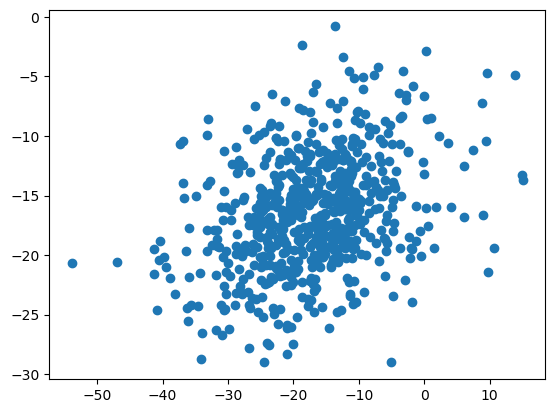

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(transport.values, t_umo_obs.dv_dz_times_X.values)

In [ ]:
from sklearn.metrics import r2_score

r2_score(t_umo_obs.dv_dz_times_X.values, transport.values)

-2.494976133393856

## Merging to the boundaries 

In [5]:
ds_argo_merged_10days, _ = load_merged_argo_dataset_and_tumo('10D', lat_bounds = lat_bounds)

def calc_merged_profiles_from_ds_argo_per_t(ds_argo_ti, compartments):
    ds_argo_ti = ds_argo_ti.sortby('lon')
    ds_argo_ti = ds_argo_ti.assign_coords(pos_i = ('pos', np.arange(ds_argo_ti.lon.shape[0])))

    compartment_profiles = []
    for compartment in compartments:
        argo_pos_mask = (ds_argo_ti.lon >= compartment[1]) & (ds_argo_ti.lon <= compartment[2]) & (ds_argo_ti.profile_mask == 1)

        if argo_pos_mask.sum() == 0:
            return None

        ds_argo_ti_comp = ds_argo_ti.where(argo_pos_mask, drop = True)
        valid_values_mask =(~ds_argo_ti_comp.temperature.isnull())

        if compartment[3] == 'west':
            westward_indices = ds_argo_ti_comp.pos_i.where(valid_values_mask).min('pos')
            westward_indices = westward_indices.fillna(westward_indices.min()).astype(int)
            merged_profile = ds_argo_ti.isel(pos = westward_indices)
        elif compartment[3] == 'east':
            eastward_indices = ds_argo_ti_comp.pos_i.where(valid_values_mask).max('pos')
            eastward_indices = eastward_indices.fillna(eastward_indices.max()).astype(int)
            merged_profile = ds_argo_ti.isel(pos = eastward_indices)
        else:
            raise ValueError('Unknown compartment direction')
        merged_profile = merged_profile.drop_vars('pos')
        compartment_profiles.append(merged_profile)

    compartment_profiles = xr.concat(compartment_profiles, dim = 'pos')
    compartment_profiles = compartment_profiles.assign_coords(pos = [c[0] for c in compartments])

    return compartment_profiles


compartments = [
    ['west_p', -76.74, -70, 'west'],
    ['mar_west_p', -60, -47, 'east'],
    ['mar_east_p', -47, -40, 'west'],
    ['east_p', -30, -13.5, 'east']
]

ds_argo_compartment_list = []
time_is_argo_compartment_list = []
for i in range(ds_argo_merged_10days.time.shape[0]):
    ds_compartment_ti = calc_merged_profiles_from_ds_argo_per_t(ds_argo_merged_10days.isel(time = i), compartments)
    
    if ds_compartment_ti is None:
        continue
    ds_argo_compartment_list.append(ds_compartment_ti)
    time_is_argo_compartment_list.append(i)
    
ds_argo_compartment_before_smooth = xr.concat(ds_argo_compartment_list, dim = 'time').assign_coords(time = ds_argo_merged_10days.time.isel(time = time_is_argo_compartment_list))

ds_argo_compartment_before_smooth['lon'] = ds_argo_compartment_before_smooth.lon.median('z')

if time_smoothing != '10D':
    ds_argo_compartment = ds_argo_compartment_before_smooth.resample(time = time_smoothing).mean()
else:
    ds_argo_compartment = ds_argo_compartment_before_smooth
ds_argo_compartment = ds_argo_compartment.where(ds_argo_compartment.profile_mask == 1, drop = True)


ds_argo_compartment

<xarray.Dataset>
Dimensions:       (time: 360, pos: 4, z: 242)
Coordinates:
  * time          (time) datetime64[ns] 2006-12-28 2007-01-07 ... 2021-11-29
  * z             (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
    pressure      (z) float64 4.82e+03 4.8e+03 4.78e+03 ... 40.0 20.0 0.0
    lon           (time, pos) float64 -72.33 -52.5 -41.25 ... -40.27 -21.46
    lat           (time, pos, z) float64 26.46 26.46 26.46 ... 26.33 26.33 26.33
    pos_i         (time, pos, z) int64 1 1 1 1 1 1 1 1 ... 44 44 44 44 44 44 44
  * pos           (pos) <U10 'west_p' 'mar_west_p' 'mar_east_p' 'east_p'
Data variables:
    temperature   (time, pos, z) float64 nan nan nan nan ... 22.73 22.72 22.7
    salinity      (time, pos, z) float64 nan nan nan nan ... 37.33 37.29 37.29
    profile_mask  (time, pos, z) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ct            (time, pos, z) float64 nan nan nan nan ... 22.65 22.64 22.63
    rho           (time, pos, z) float64 nan nan nan ... 1.026e+03 1.026e+03

## Aggregated profiles


Merged to compartments: 

In [6]:
import hvplot.xarray
ds_argo_compartment.lon.isel().drop_vars('lon').hvplot( by = 'pos', subplots = False, x = 'lon', y = 'time')


/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:NdOverlay   [pos]
   :Curve   [lon]   (time)

Naive binning:

In [7]:
lon_bined_argos

<xarray.Dataset>
Dimensions:       (z: 242, pos: 29, time: 653)
Coordinates:
  * z             (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * pos           (pos) object (-88.0, -85.31] ... (-12.69, -10.0]
  * time          (time) datetime64[ns] 2004-04-02 2004-04-12 ... 2022-02-07
    pressure      (z) float64 4.82e+03 4.8e+03 4.78e+03 ... 40.0 20.0 0.0
Data variables:
    temperature   (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    salinity      (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    profile_mask  (time, pos) float64 nan nan nan nan nan ... nan nan 1.0 nan
    ct            (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan
    rho           (time, pos, z) float64 nan nan nan nan nan ... nan nan nan nan

## Baseline 1

Use the merged product to append this to the $dvdz$ of the rapid array and calculate the tranport.

In [8]:
# Loading the dv_dz data from the rapid calculation 
dv_dz_obs = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_obs.nc')
dv_dz_obs = dv_dz_obs.resample(time = time_smoothing).mean()
dv_dz_obs

<xarray.Dataset>
Dimensions:        (z: 242, time: 653)
Coordinates:
  * z              (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * time           (time) datetime64[ns] 2004-04-02 2004-04-12 ... 2022-02-07
Data variables:
    dv_dz_times_X  (time, z) float64 -1.81 -1.795 -1.728 -1.664 ... nan nan nan

In [9]:

def calc_umo_tranport(ds_pos, obs_dv_dz = None, depth_obs_concat = -1000):

    g = 9.81
    f = 2 * 7.292116E-5 * np.sin(np.deg2rad(26.5))
    rho0 = 1025.0
    zref = -4800

    rho_diff = xr.concat(
            [
                (
                    ds_pos.isel(pos=start_i + 1).squeeze(drop=True).rho
                    - ds_pos.isel(pos=start_i).squeeze(drop=True).rho
                ).assign_coords(box=f"{start_i}_{start_i+1}")
                for start_i in range(ds_pos.pos.shape[0] - 1)
            ],
            dim="box"
        )

    dv_dz = (- rho_diff * g / f / rho0).sum("box").where(
                (~(- rho_diff * g / f / rho0).isnull()).sum("box") > 0
            ).rename("dv_dz_times_X")

    if obs_dv_dz is not None:

        dv_dz = xr.where(
            (~dv_dz.where(dv_dz.z > depth_obs_concat).isnull()),
            dv_dz,
            obs_dv_dz.dv_dz_times_X.data,
        )

    # # cut the surface 
    dv_dz = dv_dz.where(dv_dz.z < -150)

    _dv_dz = dv_dz.isel(z=slice(-40, None))
    dv_dz_fillup = xr.where(
        ~dv_dz.isnull(),
        dv_dz,
        (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz.z)
    )
    
    dv_dz = dv_dz_fillup
    
    transp_umo = (-(
            ((dv_dz.isel(z=slice(None, None, -1)).cumsum("z") * 20.0))
            - ((dv_dz.isel(z=slice(None, None, -1)).cumsum("z") * 20.0)).sel(z=zref, method="nearest")
        ).cumsum("z") * 20.0 / 1e6).sel(z=-1000, method="nearest")

    return transp_umo, dv_dz

In [10]:
def cacluate_transport_neighboring_filled_pos(ds_pos_rho, min_argo_depth):
    transports = []
    dv_dz_ts = []

    lon_mask_deeper_than = (~ds_pos_rho.rho.isnull()).sum('z') >= (~ds_pos_rho.z.where(ds_pos_rho.z > min_argo_depth).isnull()).sum()
    valid_times_mask = lon_mask_deeper_than.sum('pos') > 1

    ds_pos_rho = ds_pos_rho.where(valid_times_mask, drop = True)

    for i in range(ds_pos_rho.time.shape[0]):

        ds_pos_rho_t = ds_pos_rho.isel(time = i)

        lon_mask_deeper_than1000dbar = (~ds_pos_rho_t.rho.isnull()).sum('z') >= (~ds_pos_rho_t.z.where(ds_pos_rho_t.z > min_argo_depth).isnull()).sum()
        

        ds_pos_rho_t_valid = ds_pos_rho_t.where(lon_mask_deeper_than1000dbar, drop = True)
        try:
            transport, dv_dz_t = calc_umo_tranport(ds_pos_rho_t_valid, dv_dz_obs.sel(time = ds_pos_rho_t.time, method= 'nearest'), depth_obs_concat=min_argo_depth)
            # transport, dv_dz_t = calc_umo_tranport(ds_pos_rho_t_valid, None, depth_obs_concat=min_argo_depth)
        except Exception as e:
            # print the time index and raise the error
            print(i)
            raise e
        
        transports.append(transport)
        dv_dz_ts.append(dv_dz_t)


    transport = xr.concat(transports, dim = 'time').assign_coords(time = ds_pos_rho.time.isel(time = slice(None, None)))
    ds_dv_dz = xr.concat(dv_dz_ts, dim = 'time').assign_coords(time = ds_pos_rho.time.isel(time = slice(None, None)))

    return transport, ds_dv_dz

In [11]:
t_binned_argo_1000, dv_dz_binned_argo_1000 = cacluate_transport_neighboring_filled_pos(lon_bined_argos, -1000)
t_binned_argo_2000, dv_dz_binned_argo_2000 = cacluate_transport_neighboring_filled_pos(lon_bined_argos, -2000)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
t_merged_argo_1000, dv_dz_merged_argo_1000 = cacluate_transport_neighboring_filled_pos(ds_argo_compartment, -1000)
t_merged_argo_2000, dv_dz_merged_argo_2000 = cacluate_transport_neighboring_filled_pos(ds_argo_compartment, -2000)

In [593]:
(
    (
        t_binned_argo_1000.hvplot(label = 'argo_1000dbar')
        * t_binned_argo_2000.hvplot(label = 'argo_2000dbar')
        * t_umo_obs.hvplot(label = 'rapid')
    )
    + (
        t_merged_argo_1000.hvplot(label = 'merged_1000dbar', color = 'gray')
        * t_merged_argo_2000.hvplot(label = 'merged_2000dbar', color = 'gray', line_dash = 'dashed')
        * t_umo_obs.hvplot(label = 'rapid')
    )
    # + (
    #     dv_dz_binned_argo_1000.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'argo_1000dbar')
    #     * dv_dz_binned_argo_2000.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'argo_2000dbar')
    #     * dv_dz_obs.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'obs')
    
    # )
    # + (
    #     (t_merged_argo_1000 - t_binned_argo_1000).hvplot(label = 'merged-binned_1000dbar')
    #     * (t_merged_argo_2000 - t_binned_argo_2000).hvplot(label = 'merged-binned_2000dbar')
        
    # )
).cols(1).opts(title = f'For {time_smoothing} as smoothing')


/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

:Layout
   .Overlay.I  :Overlay
      .Curve.Argo_1000dbar :Curve   [time]   (dv_dz_times_X)
      .Curve.Argo_2000dbar :Curve   [time]   (dv_dz_times_X)
      .Curve.Rapid         :Curve   [time]   (dv_dz_times_X)
   .Overlay.II :Overlay
      .Curve.Merged_1000dbar :Curve   [time]   (dv_dz_times_X)
      .Curve.Merged_2000dbar :Curve   [time]   (dv_dz_times_X)
      .Curve.Rapid           :Curve   [time]   (dv_dz_times_X)

In [ ]:
(
    (
        dv_dz_binned_argo_1000.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'argo_1000dbar')
        * dv_dz_binned_argo_2000.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'argo_2000dbar')
        * dv_dz_obs.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'obs')
    )
    + (
        dv_dz_merged_argo_1000.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'merged_1000dbar')
        * dv_dz_merged_argo_2000.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'merged_2000dbar')
        * dv_dz_obs.mean('time').hvplot(x = 'z', y = 'dv_dz_times_X', label = 'obs')
    )
).cols(1)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

:Layout
   .Overlay.I  :Overlay
      .Curve.Argo_1000dbar :Curve   [z]   (dv_dz_times_X)
      .Curve.Argo_2000dbar :Curve   [z]   (dv_dz_times_X)
      .Curve.Obs           :Curve   [z]   (dv_dz_times_X)
   .Overlay.II :Overlay
      .Curve.Merged_1000dbar :Curve   [z]   (dv_dz_times_X)
      .Curve.Merged_2000dbar :Curve   [z]   (dv_dz_times_X)
      .Curve.Obs             :Curve   [z]   (dv_dz_times_X)

In [ ]:
t_binned_argo_1000.sel(time = slice("1-1-2010", None))

<xarray.DataArray 'dv_dz_times_X' (time: 148)>
array([-18.10661166, -19.85648943, -32.8150896 , -26.19810321,
       -13.79394784, -25.73871102,  -5.46281503, -10.04230002,
       -16.48338246, -18.27233829, -25.19381886, -30.55493376,
       -25.75730515, -24.89033964, -27.5557065 , -29.37810431,
       -28.72513376, -16.64747472, -13.32248882, -18.64724004,
       -19.6111706 , -13.98634724,   6.68162147, -12.56678158,
       -12.59972282, -10.15065353, -13.12747464, -13.16272616,
       -17.13333932, -11.65594539,  -6.85703533, -15.76750124,
       -21.94051952,  -8.4274053 ,  -7.71515697, -11.26894786,
       -13.93262583, -10.97353476, -13.50292799, -20.59871215,
       -14.46258088,  -9.94394828, -10.31279358,  -9.75370252,
       -11.49442657, -11.07999122,  -9.55124535, -13.79396019,
       -17.67502441, -18.17313145, -20.50795245, -14.16635398,
       -21.97702389, -36.86647939, -22.43148507, -13.52009419,
       -26.39227351, -23.2982955 , -20.23552383, -22.46479482,
       -28.02330189, -14.10372079,  -9.64034001,  -5.99951338,
       -11.9769065 , -23.45752829, -19.1618464 , -30.59766977,
       -27.73232485, -20.94024226, -23.80495721, -14.56800999,
       -14.43611041,  -5.61220653, -21.60064958, -13.6854753 ,
       -25.33892498, -26.62058472, -18.02749   , -26.49416738,
       -31.25005814, -24.35718893,   0.70659098,  -9.72915918,
        -6.64242214, -38.66853554, -40.58438464, -17.60297499,
       -21.8813329 , -29.85084509,  -4.47135648, -11.14173499,
        10.7736448 , -26.00536265, -22.79492602,  -9.76305032,
       -15.96376348,   8.08974891, -20.4920657 , -24.93116528,
       -29.79097634, -20.89558196, -18.70450991, -39.02236458,
       -34.40511029, -21.59404132, -13.21372285, -22.26404959,
       -26.54796755, -27.26087873, -32.7836094 , -18.44527268,
       -20.93338827, -33.19981474, -37.03136145, -29.61437902,
       -20.78890382, -25.94991561, -16.42267171, -26.39835811,
       -20.16440098, -20.17693357, -20.30428409, -17.20019472,
       -14.96591691,  -9.44469239, -19.00704281, -25.61073848,
       -27.87301228, -16.62441819, -32.21859695,  -6.30667788,
       -12.08102916, -17.94253118, -20.13444501, -25.02635631,
       -17.22076919,   3.63512902, -14.35747336,  -9.26785327,
        -7.51434278, -15.28836516, -14.38339946,  -5.57765485,
       -12.66669768, -11.98191977, -20.58657777, -17.05331702])
Coordinates:
    z        float64 -1e+03
  * time     (time) datetime64[ns] 2010-01-01 2010-01-31 ... 2022-01-28

In [ ]:
# Print the R2 score for the 1000 dbar and 2000 dbar transport to the rapid calculation
# For this make a fancy format in form of a table
from sklearn.metrics import r2_score, mean_absolute_error

print('R2 score for the 1000 dbar transport')
print('-------------------------------------')
print(f'Binned: {r2_score(t_umo_obs.sel(time = t_binned_argo_1000.time, method = "nearest").dv_dz_times_X.values, t_binned_argo_1000.values)}')
print(f'Merged: {r2_score(t_umo_obs.sel(time = t_merged_argo_1000.time, method = "nearest").dv_dz_times_X.values, t_merged_argo_1000.values)}')
print('-------------------------------------')
print('R2 score for the 2000 dbar transport')
print('-------------------------------------')
print(f'Binned: {r2_score(t_umo_obs.sel(time = t_binned_argo_2000.time, method = "nearest").dv_dz_times_X.values, t_binned_argo_2000.values)}')
print(f'Merged: {r2_score(t_umo_obs.sel(time = t_merged_argo_2000.time, method = "nearest").dv_dz_times_X.values, t_merged_argo_2000.values)}')
print('-------------------------------------')
print('MAE score for the 1000 dbar transport')
print('-------------------------------------')
print(f'Binned: {mean_absolute_error(t_umo_obs.sel(time = t_binned_argo_1000.time, method = "nearest").dv_dz_times_X.values, t_binned_argo_1000.values):.2f} Sv')
print(f'Merged: {mean_absolute_error(t_umo_obs.sel(time = t_merged_argo_1000.time, method = "nearest").dv_dz_times_X.values, t_merged_argo_1000.values):.2f} Sv')
print('-------------------------------------')
print('MAE score for the 2000 dbar transport')
print('-------------------------------------')
print(f'Binned: {mean_absolute_error(t_umo_obs.sel(time = t_binned_argo_2000.time, method = "nearest").dv_dz_times_X.values, t_binned_argo_2000.values):.2f} Sv')
print(f'Merged: {mean_absolute_error(t_umo_obs.sel(time = t_merged_argo_2000.time, method = "nearest").dv_dz_times_X.values, t_merged_argo_2000.values):.2f} Sv')

R2 score for the 1000 dbar transport
-------------------------------------
Binned: -2.2823899653295054
Merged: -1.1517757417301064
-------------------------------------
R2 score for the 2000 dbar transport
-------------------------------------
Binned: -4.34789847710499
Merged: -2.597293541638154
-------------------------------------
MAE score for the 1000 dbar transport
-------------------------------------
Binned: 6.72 Sv
Merged: 5.34 Sv
-------------------------------------
MAE score for the 2000 dbar transport
-------------------------------------
Binned: 8.71 Sv
Merged: 6.72 Sv


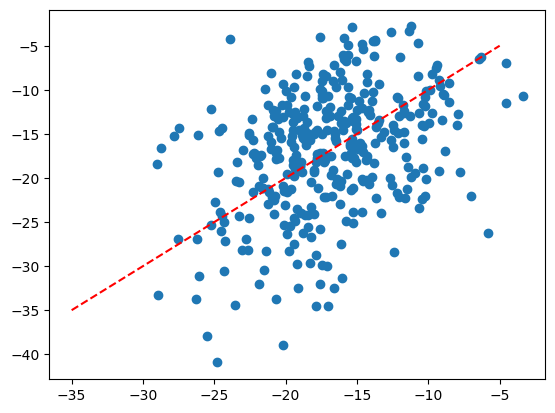

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(t_umo_obs.sel(time = t_merged_argo_1000.time, method = "nearest").dv_dz_times_X.values, t_merged_argo_1000.values)

plt.plot([-35, -5], [-35, -5], 'r--')

## Baseline 2

In [ ]:
input_X = ds_argo_compartment

In [ ]:


# standardize the rho values at the bins
from copy import deepcopy
input_X

<xarray.Dataset>
Dimensions:       (time: 360, pos: 4, z: 242)
Coordinates:
  * z             (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * pos           (pos) <U10 'west_p' 'mar_west_p' 'mar_east_p' 'east_p'
  * time          (time) datetime64[ns] 2006-12-28 2007-01-07 ... 2021-11-29
    pressure      (z) float64 4.82e+03 4.8e+03 4.78e+03 ... 40.0 20.0 0.0
Data variables:
    temperature   (time, pos, z) float64 nan nan nan nan ... 22.73 22.72 22.7
    salinity      (time, pos, z) float64 nan nan nan nan ... 37.33 37.29 37.29
    profile_mask  (time, pos, z) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ct            (time, pos, z) float64 nan nan nan nan ... 22.65 22.64 22.63
    rho           (time, pos, z) float64 nan nan nan ... 1.026e+03 1.026e+03

In [ ]:
dv_dz_obs = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_obs.nc')
dv_dz_obs = dv_dz_obs.resample(time = time_smoothing).mean()


_dv_dz = dv_dz_obs.isel(z=slice(-40, None)).dv_dz_times_X
dv_dz_obs_fillup = xr.where(
    ~dv_dz_obs.isnull(),
    dv_dz_obs,
    (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz_obs.z)
)
target_y = dv_dz_obs_fillup.dv_dz_times_X
target_y = target_y.sel(time = input_X.time, method = 'nearest')

valid_ts_mask = target_y.isnull().sum('z') == 0
target_y = target_y.where(valid_ts_mask, drop = True)
input_X = input_X.isel(time = valid_ts_mask.data)


In [ ]:
permute = False
train_ratio = .5
if permute: 
    blocks_permuted_indices = np.concatenate([np.arange(starti, min(starti+12, input_X.time.shape[0])) for starti in np.random.permutation(np.arange(0, input_X.time.shape[0], 12))])
else :
    blocks_permuted_indices = np.arange(input_X.time.shape[0])


train_indices = blocks_permuted_indices[:int( train_ratio * blocks_permuted_indices.shape[0])]
test_indices = blocks_permuted_indices[int(train_ratio * blocks_permuted_indices.shape[0]):]

In [ ]:

rho_mean = input_X.rho.isel(time = train_indices).mean(['time', 'pos'])
rho_std = input_X.rho.isel(time = train_indices).std(['time', 'pos', 'z'])

def standardize_rho(ds_pos, rho_mean=None, rho_std=None):
    ds_pos = deepcopy(ds_pos)
    ds_pos["rho"] = (ds_pos["rho"] - rho_mean) / rho_std
    return ds_pos

input_X_std = standardize_rho(
    input_X,
    rho_mean=rho_mean, 
    rho_std=rho_std,
)

input_X_std = input_X_std.fillna(0)
input_X_std = input_X_std.rho.stack(feature = ('pos', 'z'))

In [ ]:

train_X = input_X_std.values[train_indices]
test_X = input_X_std.values[test_indices]

train_y = target_y.values[train_indices]
test_y = target_y.values[test_indices]

In [ ]:
mean_per_z = np.mean(train_y, axis = 0)
std_per_z = np.std(train_y, axis = 0)

train_y_scaled = (train_y - mean_per_z) / std_per_z
test_y_scaled = (test_y - mean_per_z) / std_per_z

In [ ]:
from sklearn.linear_model import Lasso, MultiTaskLassoCV, Ridge, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct

In [ ]:
# regressor = Lasso(alpha=.1).fit(train_X, train_y)
regressor = Ridge(alpha=.68).fit(train_X, train_y_scaled)
# regressor = RidgeCV(alphas=[.01, .05,.08,.1, .15,.3, .5, 1, 5, 10]).fit(train_X, train_y_scaled)
# regressor = GaussianProcessRegressor(DotProduct() + WhiteKernel()).fit(train_X, train_y)
# regressor = MLPRegressor(hidden_layer_sizes=(1024,1024, 512), max_iter=1000, alpha=.001,
                    # solver='adam', verbose=10,  random_state=21,tol=0.000000001, learning_rate_init=1e-3, learning_rate='adaptive', validation_fraction=.1, early_stopping=True, n_iter_no_change=40).fit(train_X, train_y_scaled)

In [ ]:
regressor.score(test_X, test_y_scaled)#, regressor.alpha_

-0.6585109285362993

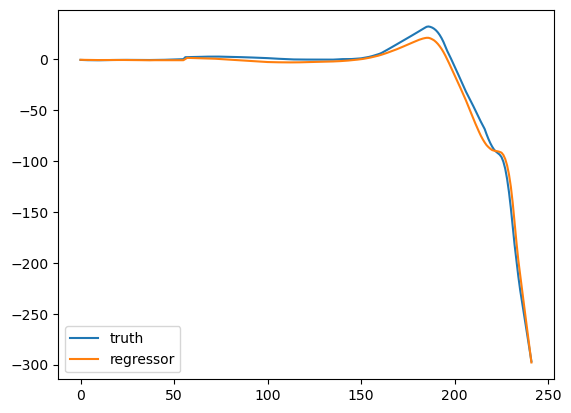

In [ ]:
import matplotlib.pyplot as plt
i = 3

plt.plot(test_y[i], label = 'truth')
plt.plot(((regressor.predict(test_X) * std_per_z) + mean_per_z)[i], label = 'regressor')
plt.legend()

In [54]:

def prediction_to_tranport(prediction, time_array, z_array ):

    dv_dz_prediction = xr.DataArray(
        prediction,
        dims = ['time', 'z'],
        coords = {
            'time': time_array,
            'z': z_array
        }
    ).rename('dv_dz_times_X')

    transp_umo_prediction = (-(
        ((dv_dz_prediction.isel(z=slice(None, None, -1)).cumsum("z") * 20.0))
        - ((dv_dz_prediction.isel(z=slice(None, None, -1)).cumsum("z") * 20.0)).sel(z=-4800, method="nearest")
    ).cumsum("z") * 20.0 / 1e6).sel(z=-1000, method="nearest")

    return transp_umo_prediction


In [ ]:
test_predictions = regressor.predict(test_X)
test_predictions = (test_predictions * std_per_z) + mean_per_z
transp_umo_prediction = prediction_to_tranport(test_predictions, target_y.time.isel(time = test_indices), target_y.z)


In [ ]:
(
    transp_umo_prediction.hvplot(label = 'LR')
    * t_umo_obs.sel(time = transp_umo_prediction.time, method = 'nearest').hvplot(label = 'rapid')
    # * t_merged_argo_2000.sel(time = transp_umo_prediction.time, method = 'nearest').hvplot(label = 'merged_2000dbar')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.LR    :Curve   [time]   (dv_dz_times_X)
   .Curve.Rapid :Curve   [time]   (dv_dz_times_X)

In [ ]:
# calc R2 score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
print(f'R2: {r2_score(t_umo_obs.sel(time = transp_umo_prediction.time, method = "nearest").dv_dz_times_X.values, transp_umo_prediction.values)}')
print(f'MAE: {mean_absolute_error(t_umo_obs.sel(time = transp_umo_prediction.time, method = "nearest").dv_dz_times_X.values, transp_umo_prediction.values)}')
print(f'MSE: {mean_squared_error(t_umo_obs.sel(time = transp_umo_prediction.time, method = "nearest").dv_dz_times_X.values, transp_umo_prediction.values)}')

R2: -0.06658158660240887
MAE: 3.662747445923182
MSE: 23.94941808615473


## Baseline 4

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
dv_dz_obs = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_obs.nc')
dv_dz_obs = dv_dz_obs.resample(time = time_smoothing).mean()


_dv_dz = dv_dz_obs.isel(z=slice(-40, None)).dv_dz_times_X
dv_dz_obs_fillup = xr.where(
    ~dv_dz_obs.isnull(),
    dv_dz_obs,
    (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz_obs.z)
)
target_y = dv_dz_obs_fillup.dv_dz_times_X
target_y = target_y.sel(time = input_X.time, method = 'nearest')

valid_ts_mask = target_y.isnull().sum('z') == 0
target_y = target_y.where(valid_ts_mask, drop = True)

In [ ]:
pca = PCA(n_components=15).fit(train_y)

(array([ 9., 14., 43., 60., 62., 73., 49., 12.,  6.,  4.]),
 array([-46.39211534, -36.32379483, -26.25547432, -16.1871538 ,
         -6.11883329,   3.94948722,  14.01780773,  24.08612824,
         34.15444876,  44.22276927,  54.29108978]),
 <BarContainer object of 10 artists>)

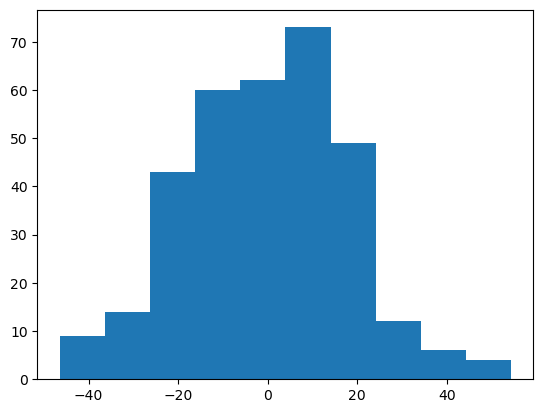

In [ ]:
plt.hist(pca.transform(target_y.values)[:, 4])

In [ ]:

regressor = Ridge(alpha=01.4).fit(train_X, pca.transform(train_y))


# regressor = MLPRegressor(hidden_layer_sizes=(1024,512, 32), max_iter=1000, alpha=.001,
#                     solver='adam', verbose=10,  random_state=21,tol=0.000000001, learning_rate_init=1e-3, learning_rate='adaptive', validation_fraction=.1, early_stopping=True, n_iter_no_change=40).fit(train_X, pca.transform(train_y))

In [ ]:
regressor.score(test_X, pca.transform(test_y))

-0.38743108695739764

In [ ]:
test_predictions = regressor.predict(test_X)

test_predictions = pca.inverse_transform(test_predictions)

transp_umo_prediction = prediction_to_tranport(test_predictions, target_y.time.isel(time = test_indices), target_y.z)


In [ ]:
(
    transp_umo_prediction.hvplot(label = 'LR')
    * t_umo_obs.sel(time = transp_umo_prediction.time, method = 'nearest').hvplot(label = 'rapid')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.LR    :Curve   [time]   (dv_dz_times_X)
   .Curve.Rapid :Curve   [time]   (dv_dz_times_X)

In [ ]:
print(f'R2: {r2_score(t_umo_obs.sel(time = transp_umo_prediction.time, method = "nearest").dv_dz_times_X.values, transp_umo_prediction.values)}')
print(f'MAE: {mean_absolute_error(t_umo_obs.sel(time = transp_umo_prediction.time, method = "nearest").dv_dz_times_X.values, transp_umo_prediction.values)}')


R2: 0.0005035802758012187
MAE: 3.6043157621328445


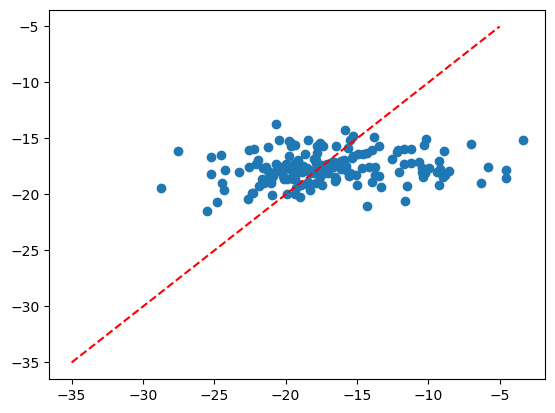

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(t_umo_obs.sel(time = transp_umo_prediction.time, method = "nearest").dv_dz_times_X.values, transp_umo_prediction.values)

plt.plot([-35, -5], [-35, -5], 'r--')

## DvDvz -> DvDz

In [336]:
dv_dz_obs = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_obs.nc')
dv_dz_obs = dv_dz_obs.resample(time = time_smoothing).mean()

dv_dz_target = dv_dz_obs.dv_dz_times_X
_dv_dz = dv_dz_target.isel(z=slice(-40, None))
dv_dz_fillup = xr.where(
    ~dv_dz_target.isnull(),
    dv_dz_target,
    (_dv_dz.isel(z=0) + _dv_dz.diff("z").ffill("z").cumsum("z")).interp(z=dv_dz_target.z)
)
dv_dz_target = dv_dz_fillup

dv_dz_target = dv_dz_target.sel(time = dv_dz_merged_argo_2000.time, method = 'nearest')

valid_ts_mask = dv_dz_target.isnull().sum('z') == 0

dv_dz_target = dv_dz_target.where(valid_ts_mask, drop = True)
dv_dz_merged_argo_2000 = dv_dz_merged_argo_2000.sel(time = dv_dz_target.time)

In [338]:
"""
This cell performs data manipulation on the input_data and longitudal_bounds variables.
It renames the 'z' dimension of input_data to 'f' and drops the 'pressure' variable.
It also renames the 'pos' dimension of longitudal_bounds to 'f' and drops the 'lon' variable.
Finally, it concatenates input_data and longitudal_bounds along the 'f' dimension.
"""

input_data = dv_dz_merged_argo_2000#.where(dv_dz_merged_argo_2000.z > -2000, drop = True)

longitudal_bounds = ds_argo_compartment.sel(time = input_data.time).lon
month = ds_argo_compartment.sel(time = input_data.time).time.dt.month.expand_dims('f', 1).assign_coords(f = [0])

# concat the inputdata with dimensions (time, z) with the longitudal bounds (time, pos) along a new dimension 'f' which consists of z and pos
input_data = input_data.rename(z = 'f' ).drop_vars('pressure')
longitudal_bounds = longitudal_bounds.rename(pos = 'f').drop_vars('lon')
input_data = xr.concat([input_data, longitudal_bounds], dim = 'f')


input_data

<xarray.DataArray 'dv_dz_times_X' (time: 296, f: 246)>
array([[ -0.71771532,  -0.83407093,  -0.95356191, ..., -58.45499039,
        -43.72700119, -16.89699936],
       [ -1.02165646,  -1.13814215,  -1.25775345, ..., -57.73099136,
        -43.69800186, -16.74500084],
       [ -1.78208066,  -1.82377626,  -1.86759728, ..., -56.06900024,
        -43.03099823, -15.95300007],
       ...,
       [ -2.1705101 ,  -2.20675184,  -2.24518042, ..., -54.55065155,
        -46.77994156, -16.91500092],
       [ -1.91936643,  -1.96484149,  -2.00842857, ..., -55.157341  ,
        -46.4311409 , -17.53899956],
       [ -1.84362215,  -1.93519516,  -2.01161543, ..., -59.26670074,
        -45.95901871, -17.89800072]])
Coordinates:
  * time     (time) datetime64[ns] 2010-03-02 2010-03-12 ... 2020-12-14
  * f        (f) <U32 '-4820.0' '-4800.0' '-4780.0' ... 'mar_east_p' 'east_p'

In [339]:
train_ratio = .75
val_percentage_of_train = .2

indices = np.arange(input_data.time.shape[0])
# np.random.shuffle(indices)

train_indices = indices[:int((1 - val_percentage_of_train)*train_ratio * indices.shape[0])]
val_indices = indices[int(train_ratio * indices.shape[0]) -int(val_percentage_of_train*train_ratio * indices.shape[0]) :int(train_ratio * indices.shape[0])]
test_indices = indices[int(train_ratio * indices.shape[0]):]


train_X = input_data.isel(time = train_indices).values
val_X = input_data.isel(time = val_indices).values
test_X = input_data.isel(time = test_indices).values


mean_dvdz_merged = np.mean(train_X, axis = 0)
std_dvdz_merged = np.std(train_X, axis = 0)

train_X_scaled = (train_X - mean_dvdz_merged) / std_dvdz_merged
val_X_scaled = (val_X - mean_dvdz_merged) / std_dvdz_merged
test_X_scaled = (test_X - mean_dvdz_merged) / std_dvdz_merged

train_y = dv_dz_target.isel(time = train_indices).values
val_y = dv_dz_target.isel(time = val_indices).values
test_y = dv_dz_target.isel(time = test_indices).values

mean_per_z = np.mean(train_y, axis = 0)
std_per_z = np.std(train_y, axis = 0)

train_y_scaled = (train_y - mean_per_z) / std_per_z
val_y_scaled = (val_y - mean_per_z) / std_per_z
test_y_scaled = (test_y - mean_per_z) / std_per_z



In [340]:
from sklearn.linear_model import Ridge, RidgeCV, MultiTaskLassoCV

regressor = RidgeCV(alphas=[.01, .05,.08,.1, .15,.3, .5, 1, 5, 10, 15, 20, 25, 50, 100, 150,200,250,500,1000]).fit(train_X_scaled, train_y_scaled)
# regressor = MultiTaskLassoCV(alphas=[.01, .05,.08,.1, .15,.3, .5, 1, 5, 10, 15, 20, 25, 50, 100, 150,200,250,500,1000]).fit(train_X_scaled, train_y_scaled)
# regressor = MultiTaskLassoCV(alphas=[.1]).fit(train_X_scaled, train_y_scaled)

In [341]:
regressor.score(test_X_scaled, test_y_scaled), regressor.alpha_

(0.3713538399139652, 25.0)

In [342]:
test_predictions = regressor.predict(test_X_scaled)

test_predictions = (test_predictions * std_per_z) + mean_per_z

transport = prediction_to_tranport(test_predictions, dv_dz_target.time.isel(time = test_indices), dv_dz_target.z)

(
    transport.hvplot(label = 'LR')
    * t_umo_obs.sel(time = transport.time, method = 'nearest').hvplot(label = 'rapid')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.LR    :Curve   [time]   (dv_dz_times_X)
   .Curve.Rapid :Curve   [time]   (dv_dz_times_X)

In [343]:
from sklearn.metrics import r2_score, mean_absolute_error
print(f'R2: {r2_score(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)}')
print(f'MAE: {mean_absolute_error(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)}')


R2: -0.27534776411273554
MAE: 4.0828090765703555


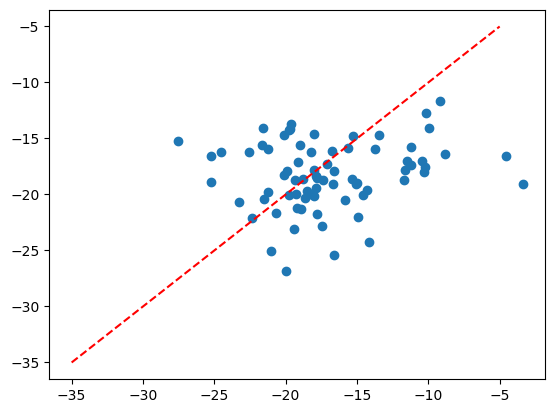

In [344]:
import matplotlib.pyplot as plt
plt.scatter(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)

plt.plot([-35, -5], [-35, -5], 'r--')

### Pytorch 

In [345]:
import torch 
from torch.utils.data import DataLoader, TensorDataset

In [346]:



dl = DataLoader(TensorDataset(torch.tensor(train_X_scaled), torch.tensor(train_y_scaled)), batch_size=8, shuffle=True)

In [651]:
## Training the fully connected neural network
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim

n_features = train_X_scaled.shape[-1] 

class PredictionToTransportModel(nn.Module):

    def __init__(self,  mean_per_z, std_per_z):
        super(PredictionToTransportModel, self).__init__()
    
        self.mean_per_z = torch.tensor(mean_per_z).float()
        self.std_per_z = torch.tensor(std_per_z).float()
        self.bottom_index = np.argmin(np.abs(dv_dz_target.z - -4800).values)
        self.amoc_index = np.argmin(np.abs(dv_dz_target.z - -1000).values)

    def forward(self, x):
        x = x * self.std_per_z + self.mean_per_z

        dv_dz_prediction = x

        return (
            -((torch.cumsum(dv_dz_prediction.flip(-1), -1) * 20) -
            (torch.cumsum(dv_dz_prediction.flip(-1), -1) * 20).flip(-1)[:, [self.bottom_index]]).cumsum(-1) * 20 / 1e6
        ).flip(-1)[:, self.amoc_index]

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(  16, 16)
        self.fc4 = nn.Linear(16, 242)

        self.dropout1 = nn.Dropout(p=.2)
        self.dropout2 = nn.Dropout(p=.5)

        self.input_mask = torch.rand(1, n_features) > .00
        self.transformer = PredictionToTransportModel(mean_per_z, std_per_z)


    def forward(self, x):
        x = x * self.input_mask.bool()
        x = torch.relu(self.fc1(x))
        # x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        # x = self.dropout2(x)
        # x = torch.relu(self.fc3(x))
        x = self.fc4(x)

        return self.transformer(x)
    
class Net_cnn(nn.Module):

    def __init__(self):
        super(Net_cnn, self).__init__()

        self.cnn1 = nn.Conv1d(1, 4, 3)
        self.maxpool1 = nn.MaxPool1d(2)
        self.cnn2 = nn.Conv1d(4, 8, 3)
        self.maxpool2 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(184, 128)
        # self.fc1 = nn.Linear(lag*100, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 242)

        self.input_mask = torch.randn(1, n_features) > .4

        self.transformer = PredictionToTransportModel(mean_per_z, std_per_z)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        
        x = torch.relu(self.fc1(x))
        x = nn.functional.dropout(x, p=.5)
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = nn.functional.dropout(x, p=.2)
        x = self.fc4(x)
        return self.transformer(x)

nets = []

transformer = PredictionToTransportModel(mean_per_z, std_per_z)

for i in range(5):
    net = Net()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay=1e-4)

    best_val_loss = 1e10
    best_model = None

    for epoch in range(500):  # loop over the dataset multiple times

        net.train()
        loss_per_epoch = 0.0
        for i, data in enumerate(dl, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            transport = transformer(labels).detach().float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())
            loss = criterion(outputs, transport)
            loss.backward()
            optimizer.step()

            # print statistics
            loss_per_epoch += loss.item()

        net.eval()
        val_prediction = net(torch.tensor(val_X_scaled).float()).detach()
        val_loss = criterion(transformer(torch.tensor(val_y_scaled)).float(), val_prediction).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(net)

        if (epoch+1) % 50 == 0:
            print(f'Epoch {epoch}, Loss: {loss_per_epoch / len(dl)}, Val loss: {val_loss}')
    nets.append(best_model)

class EnsembleNet(nn.Module):
    def __init__(self, nets):
        super(EnsembleNet, self).__init__()
        self.nets = nn.ModuleList(nets)

    def forward(self, x):
        outputs = torch.stack([net(x) for net in self.nets])
        return torch.mean(outputs, dim=0)

net = EnsembleNet(nets)
print('Finished Training')


NameError: name 'dv_dz_target' is not defined

In [348]:
test_predictions = net(torch.tensor(test_X_scaled).float()).detach().numpy()
transport = xr.DataArray(
    test_predictions,
    coords={
        'time':dv_dz_target.time.isel(time = test_indices)
    }, name='dv_dz_times_X')
(   
    transport.hvplot(label = 'NN')
        * t_umo_obs.sel(time = transport.time, method = 'nearest').hvplot(label = 'rapid')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.NN    :Curve   [time]   (dv_dz_times_X)
   .Curve.Rapid :Curve   [time]   (dv_dz_times_X)

In [349]:
colors = np.abs(transport - t_umo_obs.sel(time = transport.time, method = 'nearest'))
# ds_argo_compartment.lon.sel(time = colors.time).drop_vars('lon').hvplot.scatter( by = 'pos', subplots = False, x = 'lon', y = 'time')
(   
    ds_argo_compartment.lon.sel(time = colors.time).isel(pos = 0).drop_vars('lon').hvplot.scatter(c = colors.dv_dz_times_X.values, cmap = 'viridis') *
    ds_argo_compartment.lon.sel(time = colors.time).isel(pos = 1).drop_vars('lon').hvplot.scatter(c = colors.dv_dz_times_X.values, cmap = 'viridis') *
    ds_argo_compartment.lon.sel(time = colors.time).isel(pos = 2).drop_vars('lon').hvplot.scatter(c = colors.dv_dz_times_X.values, cmap = 'viridis') *
    ds_argo_compartment.lon.sel(time = colors.time).isel(pos = 3).drop_vars('lon').hvplot.scatter(c = colors.dv_dz_times_X.values, cmap = 'viridis') 
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Scatter.I   :Scatter   [time]   (lon,_color)
   .Scatter.II  :Scatter   [time]   (lon,_color)
   .Scatter.III :Scatter   [time]   (lon,_color)
   .Scatter.IV  :Scatter   [time]   (lon,_color)

In [350]:

def create_prediction_figure(input_data, indices):

    test_predictions = net(torch.tensor(input_data).float()).detach().numpy()

    test_predictions = (test_predictions * std_per_z) + mean_per_z

    transport = prediction_to_tranport(test_predictions, dv_dz_target.time.isel(time = indices), dv_dz_target.z)

    return     (
        transport.hvplot(label = 'NN')
        * t_umo_obs.sel(time = transport.time, method = 'nearest').hvplot(label = 'rapid')
    )

create_prediction_figure(test_X_scaled, test_indices)

ValueError: operands could not be broadcast together with shapes (74,) (242,) 

In [351]:

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
print(f'R2: {r2_score(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)}')
print(f'MAE: {mean_absolute_error(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)}')
print(f'MSE: {mean_squared_error(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)}')



R2: -0.09715725666618069
MAE: 3.761113950724065
MSE: 23.220466778751042


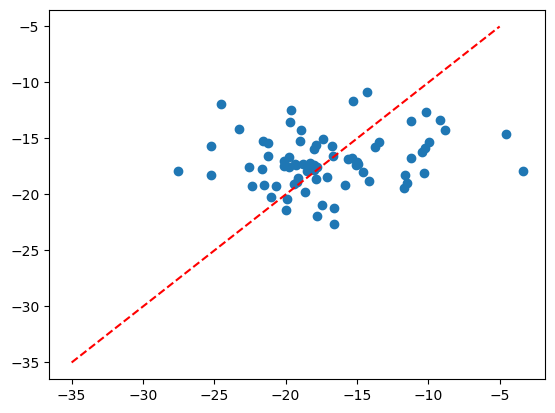

In [352]:
import matplotlib.pyplot as plt
plt.scatter(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)

plt.plot([-35, -5], [-35, -5], 'r--')


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 296 samples in 0.000s...
[t-SNE] Computed neighbors for 296 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 296 / 296
[t-SNE] Mean sigma: 74.477121
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.459080
[t-SNE] KL divergence after 300 iterations: 0.330556


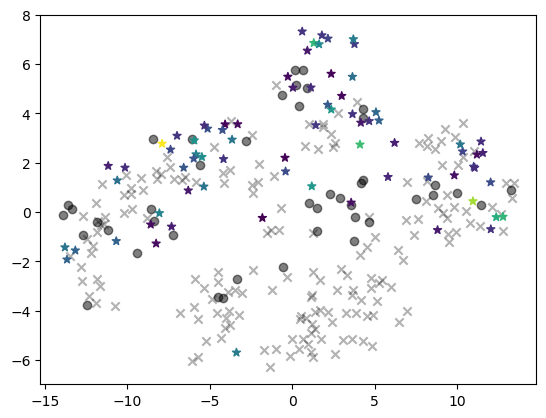

In [353]:
# import tsne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

mapped = tsne.fit_transform(input_data.values)


plt.scatter(mapped[train_indices, 0], mapped[train_indices, 1], marker='x', c = 'black', alpha= .3)
plt.scatter(mapped[val_indices, 0], mapped[val_indices, 1], marker='o', c = 'black', alpha= .5)
plt.scatter(mapped[test_indices, 0], mapped[test_indices, 1], marker='*', c = colors.dv_dz_times_X.values,)

## Single Profile Processing

We will load the ds_argo_merged dataset as thre base where each prfoile in the ten day window is present.
THen we will create 4 embedding one for each of the moorings and each profile is assigned by distance to those emebeddings. 
Each profile will create based on the currtent state and its rho values a delta that will be added to the embedding.

In [13]:
dv_dz_obs = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_obs.nc')
dv_dz_obs = dv_dz_obs.resample(time = time_smoothing).mean()
dv_dz_obs.mean('time').dv_dz_times_X#.interpolate_na('z')

<xarray.DataArray 'dv_dz_times_X' (z: 242)>
array([-1.04015015e+00, -1.13878696e+00, -1.19658096e+00, -1.24934496e+00,
       -1.25881459e+00, -1.27871813e+00, -1.29740802e+00, -1.34297442e+00,
       -1.35263648e+00, -1.36421052e+00, -1.35684977e+00, -1.31788742e+00,
       -1.30126209e+00, -1.28861637e+00, -1.28099021e+00, -1.27388338e+00,
       -1.26677547e+00, -1.26223913e+00, -1.25877451e+00, -1.25499365e+00,
       -1.25242763e+00, -1.25064599e+00, -1.25480336e+00, -1.25489215e+00,
       -1.25995713e+00, -1.26550914e+00, -1.27198597e+00, -1.27761508e+00,
       -1.28337581e+00, -1.29088130e+00, -1.30283526e+00, -1.31651383e+00,
       -1.33075456e+00, -1.34637465e+00, -1.36041017e+00, -1.37091010e+00,
       -1.35466515e+00, -1.33960201e+00, -1.32792708e+00, -1.32376611e+00,
       -1.32477997e+00, -1.31846136e+00, -1.30897317e+00, -1.29761503e+00,
       -1.28153264e+00, -1.26126851e+00, -1.24382331e+00, -1.23987478e+00,
       -1.24138605e+00, -1.24121111e+00, -1.23726110e+00, -1.22876040e+00,
       -1.21696304e+00, -1.20257783e+00, -1.18484345e+00, -1.16253996e+00,
       -4.21423340e-02,  9.80243551e-01,  9.39197311e-01,  9.00652107e-01,
        8.64697809e-01,  8.33183728e-01,  8.05172943e-01,  7.79330152e-01,
        7.52234583e-01,  7.16992432e-01,  6.80943145e-01,  6.35597333e-01,
        5.69991634e-01,  4.96503770e-01,  4.09600183e-01,  3.18279741e-01,
        2.20825283e-01,  1.67371158e-01,  4.79619087e-02, -7.43348488e-02,
       -1.95869963e-01, -3.20711221e-01, -4.48615925e-01, -5.76855771e-01,
...
        7.17866289e+00,  7.81598572e+00,  8.45725433e+00,  9.11379214e+00,
        9.78713435e+00,  1.04780614e+01,  1.12315098e+01,  1.21322175e+01,
        1.30711436e+01,  1.40387761e+01,  1.50385068e+01,  1.60534536e+01,
        1.70710140e+01,  1.81147564e+01,  1.91549242e+01,  2.01935153e+01,
        2.11816634e+01,  2.19736339e+01,  2.26314174e+01,  2.32001306e+01,
        2.36112346e+01,  2.38086026e+01,  2.36928072e+01,  2.31850704e+01,
        2.23695001e+01,  2.12370658e+01,  1.97161181e+01,  1.78614931e+01,
        1.55649439e+01,  1.26089639e+01,  9.46046991e+00,  6.06971398e+00,
        2.16271841e+00, -1.83814997e+00, -5.96062313e+00, -1.00863367e+01,
       -1.41875011e+01, -1.83549841e+01, -2.25307581e+01, -2.65433672e+01,
       -3.03500925e+01, -3.45598658e+01, -3.87833817e+01, -4.31013972e+01,
       -4.74566990e+01, -5.22038455e+01, -5.65609165e+01, -6.06888918e+01,
       -6.49463266e+01, -6.90712106e+01, -7.28679495e+01, -7.63421815e+01,
       -7.95482124e+01, -8.23021315e+01, -8.45000187e+01, -8.62006079e+01,
       -8.74330306e+01, -8.82787442e+01, -8.89322242e+01, -8.95278642e+01,
       -8.99048789e+01, -9.11454377e+01, -9.29945173e+01, -9.60094007e+01,
       -1.00671279e+02, -1.07544479e+02, -1.16918160e+02, -1.29408420e+02,
       -1.45875106e+02, -1.65553216e+02, -1.86130930e+02, -2.09590282e+02,
       -2.37399046e+02, -2.48489086e+02, -2.65971014e+02, -4.78253612e+02,
                   nan,             nan])
Coordinates:
  * z        (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0

In [14]:
from copy import deepcopy

In [15]:
ds_argo_merged_10days, t_umo_10days = load_merged_argo_dataset_and_tumo('10D', lat_bounds = lat_bounds)

compartments = [
    ['west_p', -76.74, -70, 'west'],
    ['mar_west_p', -60, -47, 'east'],
    ['mar_east_p', -47, -40, 'west'],
    ['east_p', -30, -13.5, 'east']
]

# We only take the first 2000 meters depth
ds_argo_merged_10days = ds_argo_merged_10days.where(ds_argo_merged_10days.z > -2000, drop = True)

In [16]:
# Prepare a dataset by 1) splitting the data, 2) scaling the input data 
train_slice_pos = 'start'

train_ratio = .6
val_ratio = .2

indices = np.arange(t_umo_10days.time.shape[0])
# np.random.shuffle(indices)

if train_slice_pos == 'start':
    train_indices = indices[:int(train_ratio * indices.shape[0])]
    val_indices = indices[int(train_ratio * indices.shape[0]):int((train_ratio + val_ratio) * indices.shape[0])]
    test_indices = indices[int((train_ratio + val_ratio) * indices.shape[0]):]
elif train_slice_pos == 'end':
    train_indices = indices[-int(train_ratio * indices.shape[0]):]
    val_indices = indices[-int((train_ratio + val_ratio) * indices.shape[0]): -int(train_ratio * indices.shape[0])]
    test_indices = indices[:-int((train_ratio + val_ratio) * indices.shape[0])]


rho_mean = ds_argo_merged_10days.where(ds_argo_merged_10days.profile_mask).mean(['time', 'pos']).rho
rho_std = ds_argo_merged_10days.where(ds_argo_merged_10days.profile_mask).isel(time = train_indices).std(['time', 'pos']).rho

def standardize_rho(ds_pos, rho_mean=None, rho_std=None):
    ds_pos = deepcopy(ds_pos)
    ds_pos["rho"] = (ds_pos["rho"] - rho_mean) / rho_std
    return ds_pos

ds_argo_merged_10days_std = standardize_rho(
    ds_argo_merged_10days,
    rho_mean=rho_mean, 
    rho_std=rho_std,
)

ds_argo_merged_10days_std = ds_argo_merged_10days_std.fillna(0)

train_X_scaled = ds_argo_merged_10days_std.isel(time = train_indices).rho.values
val_X_scaled = ds_argo_merged_10days_std.isel(time = val_indices).rho.values
test_X_scaled = ds_argo_merged_10days_std.isel(time = test_indices).rho.values


train_X_mask = ds_argo_merged_10days.isel(time = train_indices).profile_mask.fillna(0).astype(bool).values
val_X_mask = ds_argo_merged_10days.isel(time = val_indices).profile_mask.fillna(0).astype(bool).values
test_X_mask = ds_argo_merged_10days.isel(time = test_indices).profile_mask.fillna(0).astype(bool).values

train_X_lon = ds_argo_merged_10days.isel(time = train_indices).lon.values
val_X_lon = ds_argo_merged_10days.isel(time = val_indices).lon.values
test_X_lon = ds_argo_merged_10days.isel(time = test_indices).lon.values

train_y = t_umo_10days.isel(time = train_indices).dv_dz_times_X.values
val_y = t_umo_10days.isel(time = val_indices).dv_dz_times_X.values
test_y = t_umo_10days.isel(time = test_indices).dv_dz_times_X.values

mean_tranport = np.mean(train_y, axis = 0)
std_transport = np.std(train_y, axis = 0)

train_y_scaled = (train_y - mean_tranport) / std_transport
val_y_scaled = (val_y - mean_tranport) / std_transport
test_y_scaled = (test_y - mean_tranport) / std_transport

dv_dz_obs = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_obs.nc')
dv_dz_obs = dv_dz_obs.resample(time = time_smoothing).mean()
dv_dz_moorings = dv_dz_obs.sel(time = ds_argo_merged_10days.time).where(dv_dz_obs.z <= -2000, drop = True)

mean_dv_dz_moorings = dv_dz_moorings.isel(time = train_indices).mean(['time']).dv_dz_times_X
std_dv_dz_moorings = dv_dz_moorings.isel(time = train_indices).std(['time']).dv_dz_times_X

train_dv_dz_moorings_scaled = ((dv_dz_moorings.isel(time = train_indices).dv_dz_times_X - mean_dv_dz_moorings) / std_dv_dz_moorings).fillna(0).values
val_dv_dz_moorings_scaled = ((dv_dz_moorings.isel(time = val_indices).dv_dz_times_X - mean_dv_dz_moorings) / std_dv_dz_moorings).fillna(0).values
test_dv_dz_moorings_scaled = ((dv_dz_moorings.isel(time = test_indices).dv_dz_times_X - mean_dv_dz_moorings) / std_dv_dz_moorings).fillna(0).values




In [17]:
from torch.utils.data import DataLoader, TensorDataset, Dataset
class ProfileDataset(Dataset):
    def __init__(self, X, y, mask, lon, dv_dz, compartments):
        self.X = X
        self.y = y
        self.mask = mask
        self.lon = lon
        self.compartment = compartments 
        self.dv_dz = dv_dz

        self.len_compartments = len(compartments)

        self.X_per_compartment = []
        self.lon_per_compartment = []
        self.dv_dz_per_compartment = []

        self.min_longitude = min([comp[1] for comp in compartments])
        self.max_longitude = max([comp[2] for comp in compartments])

        self.lon_scaled = (self.lon - self.min_longitude) / (self.max_longitude - self.min_longitude)
        
        for i in range(len(self)):
            mask = self.mask[i]


            compartment_X_per_sample = []
            compartment_lon_per_sample = []

            for j in range(self.len_compartments):

                # get all profile indices that are in the compartment and in the mask 
                profile_indices = np.where((self.lon[i] > self.compartment[j][1]) & (self.lon[i] < self.compartment[j][2]) & mask.any(axis = -1))[0]

                if len(profile_indices) < 1:
                    compartment_X_per_sample.append(np.empty(0))
                    compartment_lon_per_sample.append(np.empty(0))
                    continue

                lon_compartments = self.lon_scaled[i][profile_indices]
                sorted_indices_longitude = lon_compartments.argsort()


                # If I have the sequence -5, -15, 5 the argsort will return [1, 0, 2]
                # As we want to have those profiles as last that are closes to the mooring due to the vanishing gradient 
                # For West moorings the smallest value has to be the last one
                if self.compartment[j][3] == 'west':
                    sorted_indices_longitude = sorted_indices_longitude[::-1]
                
                profile_indices = profile_indices[sorted_indices_longitude]

                compartment_X_per_sample.append(self.X[i][:, profile_indices].T)
                compartment_lon_per_sample.append(self.lon[i][profile_indices])
            

            self.X_per_compartment.append(compartment_X_per_sample)
            self.lon_per_compartment.append(compartment_lon_per_sample)
            self.dv_dz_per_compartment.append(self.dv_dz[i])


    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X_per_compartment[idx], self.y[idx], self.lon_per_compartment[idx], self.dv_dz_per_compartment[idx]

In [45]:
import torch
train_dataset = ProfileDataset(train_X_scaled, train_y, train_X_mask, train_X_lon, train_dv_dz_moorings_scaled, compartments)
val_dataset = ProfileDataset(val_X_scaled, val_y, val_X_mask, val_X_lon, val_dv_dz_moorings_scaled, compartments)
test_dataset = ProfileDataset(test_X_scaled, test_y, test_X_mask, test_X_lon, test_dv_dz_moorings_scaled, compartments)


def merge_profiles(data):
    """
        X: is a list and each entry is a list of compartments in which the profiles are stored with variable length
    """
    X, y, lon, dv_dz = zip(*data)
    X = [[torch.tensor(x_compartment).float() for x_compartment in x_sample] for x_sample in X]
    y = torch.tensor(np.array(y)).float()
    lon = [[torch.tensor(lon_compartment).float() for lon_compartment in lon_sample] for lon_sample in lon]
    dv_dz = [torch.tensor(dv_dz_sample).float() for dv_dz_sample in dv_dz]
    return X, y, lon, dv_dz

dl = DataLoader(train_dataset, batch_size=6, shuffle=True, collate_fn=merge_profiles)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=merge_profiles)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=merge_profiles)


In [68]:
from torch import nn

class PredictionToTransportModel(nn.Module):

    def __init__(self, z_scale, mean_per_z, std_per_z ):
        super(PredictionToTransportModel, self).__init__()
        self.mean_per_z = torch.tensor(mean_per_z).float()
        self.std_per_z = torch.tensor(std_per_z).float()
        self.bottom_index = np.argmin(np.abs(z_scale - -4800).values)
        self.amoc_index = np.argmin(np.abs(z_scale - -1000).values)

    def forward(self, x):
        x = x * self.std_per_z + self.mean_per_z

        dv_dz_prediction = x

        return (
            -((torch.cumsum(dv_dz_prediction.flip(-1), -1) * 20) -
            (torch.cumsum(dv_dz_prediction.flip(-1), -1) * 20).flip(-1)[:, [self.bottom_index]]).cumsum(-1) * 20 / 1e6
        ).flip(-1)[:, self.amoc_index]


class CompartmentModel(nn.Module):

    def __init__(self, n_features, n_embedding):
        super(CompartmentModel, self).__init__()
        self.n_features = n_features
        self.n_embedding = n_embedding
        self.fc1 = nn.Linear(n_features + n_embedding + 1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout1 = nn.Dropout(p=.25)
        self.fc3 = nn.Linear(64, n_embedding)
        self.dropout2 = nn.Dropout(p=.5)
        self.fc4 = nn.Linear(n_embedding, n_embedding)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class ProfileModel(nn.Module):
    def __init__(self, n_features, n_compartments, n_embedding, n_dvdz_features, z_scale):
        super(ProfileModel, self).__init__()
        self.n_compartments = n_compartments
        self.n_features = n_features
        self.n_dvdz_features = n_dvdz_features
        self.n_embedding = n_embedding
        self.fc1 = nn.Linear(n_embedding * n_compartments +n_dvdz_features  , 128)
        self.bn1 = nn.BatchNorm1d(num_features=128)
        self.fc2 = nn.Linear(128,128)
        self.dropout1 = nn.Dropout(p=.5)
        self.fc3 = nn.Linear(128,64)
        self.dropout2 = nn.Dropout(p=.33)
        self.fc4 = nn.Linear(64,64)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        self.dropout3 = nn.Dropout(p=.5)
        self.fc5 = nn.Linear(64,32)
        self.fc6 = nn.Linear(32,242)

        self.compartment_models = nn.ModuleList([CompartmentModel(n_features, n_embedding) for _ in range(n_compartments)])
        self.transformer = PredictionToTransportModel(z_scale, dv_dz_obs.dv_dz_times_X.mean('time').fillna(0).values, dv_dz_obs.dv_dz_times_X.std('time').fillna(1).values)

    def forward(self, x, lon, dv_dz):

        
        batch_embeddings = []
        for batch_i in range(len(x)):
            compartment_embeddings = []
            x_batch = x[batch_i]
            for i in range(self.n_compartments):
                x_compartment = x_batch[i]
                compartment_embedding = torch.zeros(self.n_embedding).float()
                compartment_embeddings_for_mean = []
                for x_profile, lon_profile in zip(x_compartment, lon[batch_i][i]):
                    input_to_compartment_embedding = torch.cat([x_profile, compartment_embedding, lon_profile.unsqueeze(0)]).float()
                    

                    
                    compartment_embedding = compartment_embedding + self.compartment_models[i](input_to_compartment_embedding).float()
                    # compartment_embeddings_for_mean.append(self.compartment_models[i](input_to_compartment_embedding).float())
                
                # if len(compartment_embeddings_for_mean) < 1:
                #     compartment_embedding = torch.zeros(self.n_embedding).float()
                # else:
                #     compartment_embedding = torch.stack(compartment_embeddings_for_mean).mean(dim = 0)    
                if len(x_compartment) > 0:
                    compartment_embedding /= len(x_compartment)
                compartment_embeddings.append(compartment_embedding)

            embedding_all_profiles = torch.concat(compartment_embeddings +[dv_dz[batch_i]], dim = 0)
            batch_embeddings.append(embedding_all_profiles)
        embedding_all_profiles = torch.stack(batch_embeddings)
        assert not torch.isnan(embedding_all_profiles).any(), 'NaN in embedding_all_profiles'
        x = torch.relu(self.fc1(embedding_all_profiles))
        # x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        # x = torch.relu(self.fc4(x))
        x = self.dropout3(x)
        # x = self.bn2(x)
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        x = x.squeeze(dim = -1)

        return self.transformer(x)
        



In [69]:
model = ProfileModel(train_X_scaled.shape[1], len(compartments), 32, train_dv_dz_moorings_scaled.shape[1], ds_argo_merged_10days.z)
model.float()
for X, y, lon, dvdz in dl:

    print(model(X, lon, dvdz).squeeze(), y)

    break

tensor([-22.7221, -22.6504, -22.6786, -22.6863, -22.6291, -22.6129],
       grad_fn=<SqueezeBackward0>) tensor([ -6.4260, -14.7928, -19.1902, -21.2151, -11.2558, -12.3803])


In [70]:
from torch import optim

torch.random.manual_seed(42)
np.random.seed(42)


model = ProfileModel(train_X_scaled.shape[1], len(compartments), 16, train_dv_dz_moorings_scaled.shape[1] , ds_argo_merged_10days.z)
model.float()
criterion = nn.MSELoss()
criterion = nn.L1Loss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5, momentum=.9)
num_epochs = 100
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

best_val_loss = 1e10
best_model = None
best_epoch = 0

for epoch in range(num_epochs):  # loop over the dataset multiple times

    model.train()
    loss_per_epoch = 0.0
    for i, data in enumerate(dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        X, y, lon, dvdz = data
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(X, lon, dvdz)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # print statistics
        loss_per_epoch += loss.item()

    lr_scheduler.step()

    model.eval()
    total_val_loss = 0.
    for X, y, lon, dvdz in val_dl:
        val_prediction = model(X, lon, dvdz).detach()
        val_loss = criterion(val_prediction, y).item()

        total_val_loss += val_loss

    total_val_loss /= len(val_dl)
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        best_epoch = epoch
        best_model = deepcopy(model)
        print('New best model found in epoch: ', epoch, 'with val loss: ', total_val_loss)

    if (epoch+1) % 3 == 0:
        print(f'Epoch {epoch}, Loss: {loss_per_epoch / len(dl)}, Val loss: {total_val_loss}')

    if epoch - best_epoch > 20:
        break


New best model found in epoch:  0 with val loss:  4.656187200546265
New best model found in epoch:  1 with val loss:  3.706190061569214
New best model found in epoch:  2 with val loss:  3.4524550437927246
Epoch 2, Loss: 3.9212065013972195, Val loss: 3.4524550437927246
Epoch 5, Loss: 3.65835681106105, Val loss: 3.521980333328247
Epoch 8, Loss: 3.6680169809948313, Val loss: 3.468726968765259
New best model found in epoch:  9 with val loss:  3.439468002319336
Epoch 11, Loss: 3.5343174040317535, Val loss: 3.500440073013306
Epoch 14, Loss: 3.4246443166877283, Val loss: 3.50666766166687
Epoch 17, Loss: 3.504119407046925, Val loss: 3.472227954864502
New best model found in epoch:  18 with val loss:  3.399573040008545
Epoch 20, Loss: 3.549564737262148, Val loss: 3.451501417160034
Epoch 23, Loss: 3.324728133100452, Val loss: 3.4256169319152834
Epoch 26, Loss: 3.498592249371789, Val loss: 3.5059223651885985
Epoch 29, Loss: 3.475012961662177, Val loss: 3.5055400371551513
Epoch 32, Loss: 3.2867863

In [71]:
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=merge_profiles)

test_predictions = []

model = best_model
model.eval()
total_test_loss = 0.

for X, y, lon, dvdz in test_dl:

    test_prediction = model(X, lon, dvdz).detach()
    test_loss = criterion(test_prediction, y).item()

    total_test_loss += test_loss
    test_predictions.append(test_prediction)

test_predictions = torch.cat(test_predictions)

# test_predictions = (test_predictions * std_transport) + mean_tranport

In [72]:


transport = xr.DataArray(
    test_predictions,
    coords={
        'time':ds_argo_merged_10days_std.isel(time = test_indices).time
    }, name='dv_dz_times_X')
(   
    transport.hvplot(label = 'NN')
        * t_umo_obs.sel(time = transport.time, method = 'nearest').hvplot(label = 'rapid')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.NN    :Curve   [time]   (dv_dz_times_X)
   .Curve.Rapid :Curve   [time]   (dv_dz_times_X)

In [73]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
const_prediction_MAE = np.abs(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X - t_umo_obs.sel(time = ds_argo_merged_10days_std.isel(time = train_indices).time, method = "nearest").dv_dz_times_X.mean()).mean().values

mae_error = mean_absolute_error(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)

print(f'R2: {r2_score(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)}')
print(f'MAE: {mae_error}; const MAE {const_prediction_MAE}', f' improvement percentage:  {(const_prediction_MAE - mae_error) / const_prediction_MAE * 100:.2f}%')
print(f'MSE: {mean_squared_error(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)}')

R2: 0.2123487012072489
MAE: 2.8573760922270095; const MAE 3.501547184883508  improvement percentage:  18.40%
MSE: 13.848011979319013


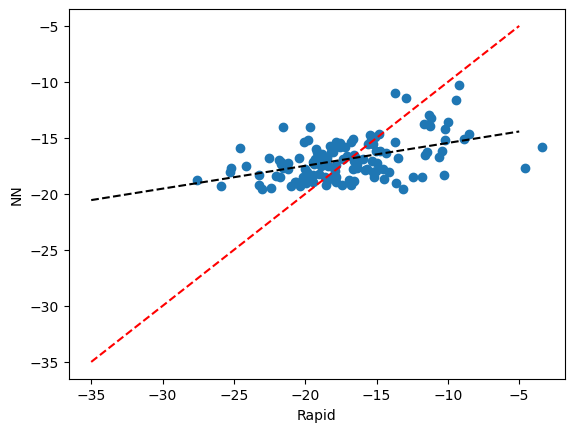

In [74]:
import matplotlib.pyplot as plt
plt.scatter(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values, transport.values)
plt.xlabel('Rapid')
plt.ylabel('NN')
plt.plot([-35, -5], [-35, -5], 'r--')

from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values.reshape(-1, 1), transport.values.reshape(-1, 1))
in_X = np.linspace(-35, -5, 100).reshape(-1, 1)
plt.plot(in_X, lr.predict(in_X), 'k--')

### What happens at the 14.11.20 and 24.11.20?

In [26]:
# Take all indices in the test index which have a very weak AMOC and we overerstimate it


weak_amoc_indices = np.where(t_umo_obs.sel(time = transport.time, method = "nearest").dv_dz_times_X.values - transport > 5)[0]

In [27]:
transport.time[weak_amoc_indices]

(
    dv_dz_obs.sel(time = transport.time).isel(time = weak_amoc_indices).dv_dz_times_X.mean('time').hvplot(label = 'mean outlier') *
    dv_dz_obs.sel(time = slice( '2015-03-01', None)).mean('time').dv_dz_times_X.hvplot(label = 'mean')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.Mean_outlier :Curve   [z]   (dv_dz_times_X)
   .Curve.Mean         :Curve   [z]   (dv_dz_times_X)

In [28]:
(
    dv_dz_binned_argo_2000.std('time').hvplot(x = 'z') * 
    dv_dz_merged_argo_2000.std('time').hvplot(x = 'z') * 
    dv_dz_obs.std('time').dv_dz_times_X.hvplot(x = 'z')
)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.I   :Curve   [z]   (dv_dz_times_X)
   .Curve.II  :Curve   [z]   (dv_dz_times_X)
   .Curve.III :Curve   [z]   (dv_dz_times_X)

In [29]:
 dv_dz_obs.sel(time = slice('2020-03-01', '2020-11-01')).mean('time').dv_dz_times_X

<xarray.DataArray 'dv_dz_times_X' (z: 242)>
array([-1.29150801e+00, -1.28516571e+00, -1.28308262e+00, -1.26456537e+00,
       -1.24618676e+00, -1.22796220e+00, -1.20651146e+00, -1.18868435e+00,
       -1.17112797e+00, -1.15342452e+00, -1.13589429e+00, -1.11280824e+00,
       -1.09698172e+00, -1.07108936e+00, -1.04952393e+00, -1.03519665e+00,
       -1.02574733e+00, -1.01545198e+00, -1.00972092e+00, -1.00177157e+00,
       -1.00886024e+00, -1.02372144e+00, -1.03253219e+00, -1.07036449e+00,
       -1.11164889e+00, -1.15195956e+00, -1.19388399e+00, -1.23543958e+00,
       -1.27665687e+00, -1.31702414e+00, -1.35700034e+00, -1.39537044e+00,
       -1.43208660e+00, -1.47663255e+00, -1.51153247e+00, -1.54303670e+00,
       -1.58023454e+00, -1.61465752e+00, -1.60973175e+00, -1.60714849e+00,
       -1.60648379e+00, -1.60102090e+00, -1.58375445e+00, -1.55482562e+00,
       -1.52652923e+00, -1.50550766e+00, -1.50946981e+00, -1.50864721e+00,
       -1.50424486e+00, -1.47407592e+00, -1.46177677e+00, -1.47044043e+00,
       -1.46272413e+00, -1.44476488e+00, -1.41643984e+00, -1.38354903e+00,
       -1.04360609e+00,  2.57349458e-01,  2.13776775e-01,  1.72937937e-01,
        1.35396495e-01,  1.00577077e-01,  7.30577446e-02,  5.54081153e-02,
        2.70681169e-02,  2.64427495e-02,  3.40542080e-02,  5.42873028e-02,
        3.34966160e-04, -6.04082721e-02, -1.31886725e-01, -2.00351031e-01,
       -2.79664717e-01, -4.07152215e-01, -5.36740170e-01, -6.69235306e-01,
       -7.72389900e-01, -9.01606084e-01, -1.03842217e+00, -1.17481884e+00,
...
        8.25486281e+00,  8.89196534e+00,  9.54341826e+00,  1.02066464e+01,
        1.08795548e+01,  1.15678129e+01,  1.23488172e+01,  1.32644661e+01,
        1.42302504e+01,  1.52448656e+01,  1.62936108e+01,  1.72553025e+01,
        1.82421764e+01,  1.92456881e+01,  2.02861714e+01,  2.13402050e+01,
        2.23465586e+01,  2.30809134e+01,  2.37256778e+01,  2.42797096e+01,
        2.47898272e+01,  2.47569112e+01,  2.44828113e+01,  2.39236909e+01,
        2.29151616e+01,  2.16678791e+01,  2.00341653e+01,  1.80048785e+01,
        1.56052935e+01,  1.28027491e+01,  9.58590106e+00,  5.97477502e+00,
        2.12757818e+00, -1.87204576e+00, -5.95349027e+00, -1.00866959e+01,
       -1.42225193e+01, -1.87118698e+01, -2.33264970e+01, -2.80129181e+01,
       -3.27420793e+01, -3.75732800e+01, -4.23406495e+01, -4.71389814e+01,
       -5.19767757e+01, -5.68211602e+01, -6.16225151e+01, -6.62596380e+01,
       -7.07015697e+01, -7.50685336e+01, -7.90159130e+01, -8.30183094e+01,
       -8.69621941e+01, -9.04277475e+01, -9.33235933e+01, -9.57226829e+01,
       -9.79518707e+01, -1.00087760e+02, -1.02612375e+02, -1.05432438e+02,
       -1.05668055e+02, -1.06099885e+02, -1.06918053e+02, -1.09195834e+02,
       -1.14043015e+02, -1.19002598e+02, -1.25402783e+02, -1.35221066e+02,
       -1.47831517e+02, -1.61752251e+02, -1.77490731e+02, -1.95947277e+02,
       -2.16687948e+02, -2.36704060e+02,             nan,             nan,
                   nan,             nan])
Coordinates:
  * z        (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0

In [30]:
((
    dv_dz_obs.sel(time = '2020-11-14').dv_dz_times_X.hvplot(label = '14.11 (obs)') *
    dv_dz_merged_argo_2000.sel(time = '2020-11-14').hvplot(label = '14.11 (argo merged)', x = 'z') * 
    dv_dz_binned_argo_2000.sel(time = '2020-11-14').hvplot(label = '14.11 (argo binned)', x = 'z') * 
    dv_dz_obs.sel(time = slice('2020-07-01', '2021-03-01')).mean('time').dv_dz_times_X.hvplot(label = 'mean')
) +(
    dv_dz_obs.sel(time = '2020-11-24').dv_dz_times_X.hvplot(label = '24.11 (obs)') *
    dv_dz_merged_argo_2000.sel(time = '2020-11-24').hvplot(label = '24.11 (argo merged)', x = 'z') * 
    dv_dz_binned_argo_2000.sel(time = '2020-11-24').hvplot(label = '24.11 (argo binned)', x = 'z') * 
    dv_dz_obs.sel(time = slice('2020-07-01', '2021-03-01')).mean('time').dv_dz_times_X.hvplot(label = 'mean')

) +(
    dv_dz_obs.sel(time = '2020-07-27').dv_dz_times_X.hvplot(label = '27.07 (obs)') *
    dv_dz_merged_argo_2000.sel(time = '2020-07-27').hvplot(label = '27.07 (argo merged)', x = 'z') * 
    dv_dz_binned_argo_2000.sel(time = '2020-07-27').hvplot(label = '27.07 (argo binned)', x = 'z') * 
    dv_dz_obs.sel(time = slice('2020-03-01', '2020-11-01')).mean('time').dv_dz_times_X.hvplot(label = 'mean')

)+(
    dv_dz_obs.sel(time = '2019-09-01').dv_dz_times_X.hvplot(label = '01.09.19 (obs)') *
    # dv_dz_merged_argo_2000.sel(time = '2019-09-01').hvplot(label = '01.09.19 (argo merged)', x = 'z') * 
    dv_dz_binned_argo_2000.sel(time = '2019-09-01').hvplot(label = '01.09.19 (argo binned)', x = 'z') * 
    dv_dz_obs.sel(time = slice('2019-03-01', '2020-02-01')).mean('time').dv_dz_times_X.hvplot(label = 'mean')

)).cols(1)

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

:Layout
   .Overlay.I   :Overlay
      .Curve.A_14_full_stop_11_left_parenthesis_obs_right_parenthesis         :Curve   [z]   (dv_dz_times_X)
      .Curve.A_14_full_stop_11_left_parenthesis_argo_merged_right_parenthesis :Curve   [z]   (dv_dz_times_X)
      .Curve.A_14_full_stop_11_left_parenthesis_argo_binned_right_parenthesis :Curve   [z]   (dv_dz_times_X)
      .Curve.Mean                                                             :Curve   [z]   (dv_dz_times_X)
   .Overlay.II  :Overlay
      .Curve.A_24_full_stop_11_left_parenthesis_obs_right_parenthesis         :Curve   [z]   (dv_dz_times_X)
      .Curve.A_24_full_stop_11_left_parenthesis_argo_merged_right_parenthesis :Curve   [z]   (dv_dz_times_X)
      .Curve.A_24_full_stop_11_left_parenthesis_argo_binned_right_parenthesis :Curve   [z]   (dv_dz_times_X)
      .Curve.Mean                                                             :Curve   [z]   (dv_dz_times_X)
   .Overlay.III :Overlay
      .Curve.A_27_full_stop_07_left_parenthesis_obs_right_parenthesis         :Curve   [z]   (dv_dz_times_X)
      .Curve.A_27_full_stop_07_left_parenthesis_argo_merged_right_parenthesis :Curve   [z]   (dv_dz_times_X)
      .Curve.A_27_full_stop_07_left_parenthesis_argo_binned_right_parenthesis :Curve   [z]   (dv_dz_times_X)
      .Curve.Mean                                                             :Curve   [z]   (dv_dz_times_X)
   .Overlay.IV  :Overlay
      .Curve.A_01_full_stop_09_full_stop_19_left_parenthesis_obs_right_parenthesis         :Curve   [z]   (dv_dz_times_X)
      .Curve.A_01_full_stop_09_full_stop_19_left_parenthesis_argo_binned_right_parenthesis :Curve   [z]   (dv_dz_times_X)
      .Curve.Mean                                                                          :Curve   [z]   (dv_dz_times_X)

In [31]:
mean_dvdz = dv_dz_obs.sel(time = slice(None, '2015-12-01')).mean('time')
std_dvdz = dv_dz_obs.sel(time = slice(None, '2015-12-01')).std('time')

((dv_dz_obs.sel(time = '2020-07-27') - mean_dvdz.dv_dz_times_X) / std_dvdz).hvplot(label = '14.11 (obs)') 


/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Curve   [z]   (dv_dz_times_X)